# Advanced optimization - Homework 2

## 1. Dataset introduction

## 2. Setup

### 2.0 Install libraries

In [461]:
# !pip install numpy
# !pip install pandas
# !pip install xlrd
# !pip install openpyxl
# !pip install seaborn

### 2.1 Import libaries

In [462]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
import random
from enum import Enum

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)
random.seed(2)

### 2.2 Setup parameters

In [463]:
# FEATURES
# employee_number
# age                   : numerical
# department            : no oder categorical
# education             : order categorical
# school                : no oder categorical
# education_field       : no oder categorical
# gender                : no oder categorical
# job_level             : oder categorical
# job_title             : no oder categorical
# job_role              : no oder categorical
# job_category          : no oder categorical
# marital_status        : no oder categorical
# performance_rating    : order categorical
# years_at_company      : numerical

# OUTPUT
# attrition             : binary output

#### 2.2.1 Dataset parameters

In [464]:
DATASET_FILE_NAME = "hr_dataset.xlsx"
NUMERICAL_FEATURES = ["age", "years_at_company"]
ORDER_CATEGORICAL_FEATURES = ["education", "job_level", "performance_rating"]
NO_ORDER_CATEGORICAL_FEATURES = ["department", "school", "education_field", "gender", "job_category", "marital_status"]
OUTPUT_NAME = ["attrition"]

In [465]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(ORDER_CATEGORICAL_FEATURES) + len(NO_ORDER_CATEGORICAL_FEATURES) + len(OUTPUT_NAME)
print("Total number of features: ", total_number_of_features)

Total number of features:  12


#### 2.2.2 GRADIENT DESCENT parameters

### 2.3 Import dataset

In [466]:
df = pd.read_excel(DATASET_FILE_NAME)

In [467]:
df

,Age,Department,Education,school,EducationField,Gender,JobLevel,jobCategory,MaritalStatus,PerformanceRating,YearsAtCompany,Attrition
0,42,FGC,3,Đại học Hà Nội,Ngôn ngữ,Female,4,Comtor,Married,4,8.863014,No
1,44,FHN,3,Đại học Bách khoa Hà Nội,Other,Female,4,Tester,Married,4,19.761644,No
2,47,FSG,3,Đại học QG Hà Nội-Khoa Kinh tế,Kinh tế,Female,4,PM,Married,3,4.501370,No
3,42,GHC,3,Đại học Bách khoa Hà Nội,Kỹ thuật,Female,4,Tester,Married,4,19.263014,No
4,43,FHN,3,Đại học Kinh tế quốc dân,Kinh tế,Female,4,Tester,Married,3,18.975342,No
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,34,JES,3,Đại học Công Nghệ TP HCM,Công nghệ,Male,4,BA,Single,3,0.917808,No
4996,24,FA VN,3,Đại học Công nghiệp TPHCM,Kỹ thuật,Male,3,Engineer,Single,4,0.189041,No
4997,28,FSG,3,Đại học Kinh tế HCM,Kinh tế,Female,3,BA,Single,4,3.235616,No
4998,29,FHM,2,NaN,Công nghệ,Male,2,Engineer,Single,3,2.252055,Yes


### 2.4 Overview of dataset

In [468]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def standardize_column_names(column_list):
    return [camel_to_snake(col) for col in column_list]

standardize_column_names(df.columns)

['age',
 'department',
 'education',
 'school',
 'education_field',
 'gender',
 'job_level',
 'job_category',
 'marital_status',
 'performance_rating',
 'years_at_company',
 'attrition']

In [469]:
df.columns = standardize_column_names(df.columns)

In [470]:
df.columns

Index(['age', 'department', 'education', 'school', 'education_field', 'gender',
       'job_level', 'job_category', 'marital_status', 'performance_rating',
       'years_at_company', 'attrition'],
      dtype='object')

<Axes: >

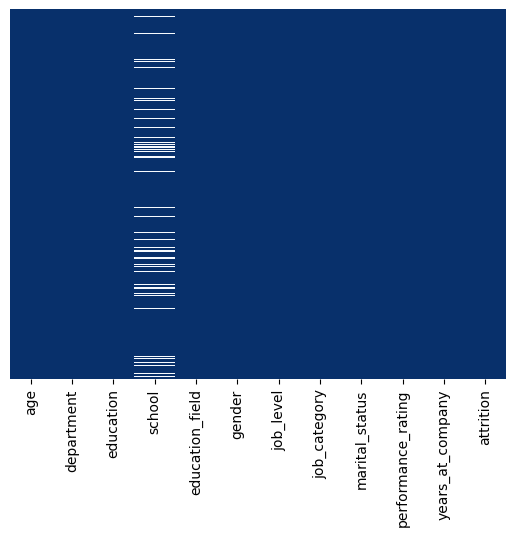

In [471]:
sns.heatmap(df.isnull(), cmap="Blues_r", cbar=False, yticklabels=False)

### 2.5 age

In [472]:
df["age"].describe()

count    5000.000000
mean       29.967600
std         4.880176
min        19.000000
25%        26.000000
50%        29.000000
75%        33.000000
max        50.000000
Name: age, dtype: float64

### 2.6 department

In [473]:
df["department"].describe()

count     4998
unique      59
top         FI
freq       766
Name: department, dtype: object

### 2.7 education

In [474]:
df["education"].describe()

count    5000.000000
mean        2.849200
std         0.500509
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: education, dtype: float64

## 3. Data cleaning

### 3.1 Data cleaning

In [475]:
# One hot encoding
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)

# Remove "employee_number"
cleaned_df = cleaned_df.iloc[:, 1:]

# Convert all boolean to integer
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == np.bool_:
        cleaned_df[col] = cleaned_df[col].astype(int)

# Convert output
cleaned_df["attrition"] = cleaned_df["attrition"].map({"Yes": 1, "No": 0})

# Move output column to the last position
attrition_column = cleaned_df.pop("attrition")
cleaned_df = pd.concat([cleaned_df, attrition_column], axis=1)

cleaned_df

,education,job_level,performance_rating,years_at_company,department_AIC,department_AMG,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,3,4,4,8.863014,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,4,4,19.761644,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,3,4,3,4.501370,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,3,4,4,19.263014,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,3,4,3,18.975342,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,4,3,0.917808,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4996,3,3,4,0.189041,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4997,3,3,4,3.235616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,2,2,3,2.252055,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


### 3.2 Data standardization

In [476]:
print("hello")

hello


### 3.3 Summary X and y

In [477]:
X_df = cleaned_df.iloc[:,:-1]
X_df

,education,job_level,performance_rating,years_at_company,department_AIC,department_AMG,department_CEP,department_DES,department_DPS,department_DXG,...,job_category_Manager,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,3,4,4,8.863014,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,4,4,19.761644,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,3,4,3,4.501370,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,3,4,4,19.263014,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,3,4,3,18.975342,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,4,3,0.917808,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4996,3,3,4,0.189041,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4997,3,3,4,3.235616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4998,2,2,3,2.252055,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [478]:
X = np.array(X_df).T
X

array([[3., 3., 3., ..., 3., 2., 3.],
       [4., 4., 4., ..., 3., 2., 3.],
       [4., 4., 3., ..., 4., 3., 3.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [479]:
X.shape

(396, 5000)

In [480]:
y_df = cleaned_df.iloc[:,-1]
y_df

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    1
4999    1
Name: attrition, Length: 5000, dtype: int64

In [481]:
y = np.array(y_df).reshape(-1, 1)
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [482]:
y.shape

(5000, 1)

### 3.4 Build Xbar (X and bias)

In [483]:
one = np.ones((1, X.shape[1]))
Xbar = np.concatenate((one, X), axis=0)
Xbar

array([[1., 1., 1., ..., 1., 1., 1.],
       [3., 3., 3., ..., 3., 2., 3.],
       [4., 4., 4., ..., 3., 2., 3.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [484]:
Xbar.shape

(397, 5000)

## 4. Build the models

### Requirements
- Neccessary features
- Best link functions

### 4.1. The simplest model

In [485]:
# y = f(w^Tx)

# f(s) = 1 / (1 + e^-s)     (logit link function)

In [486]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## 5. Algorithms optimization

### 5.1. Loss function selection

In [487]:
"""
z = b + w * x

y^ = 1 / (1 + e^-z) (sigmoid link function)

cost(y^, y) = 1/N * - (y * log(y^) + (1 - y) * log(1 - y^))

Conclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))

"""

'\nz = b + w * x\n\ny^ = 1 / (1 + e^-z) (sigmoid link function)\n\ncost(y^, y) = 1/N * - (y * log(y^) + (1 - y) * log(1 - y^))\n\nConclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))\n\n'

In [488]:
def cost(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    epsilon = 1e-10
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)  # Avoid log(0)
    return 1 / N * -(y.T.dot(np.log(y_hat)) + (1 - y).T.dot(np.log(1 - y_hat)))

In [489]:
"""
cost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))

Let A = y * log(y^)

Let B = (y - 1) * log(1 - y^)


Find dA/dw

dA/dw 
= d(y * log(y^)) / dw
= y * 1 / y^ * (dy^/dw)
= y * 1 / y^ * (dy^/dz * dz/dw)
= y * 1 / y^ * ((1 - y^) * y^ * x)
= y * (1 - y^) * x


Find dB/dw

dB/dw
= d((1 - y) * log(1 - y^)) / dw
= (1 - y) / (1 - y^) * (dy^/dw)
= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)
= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)
= (1 - y) * y^ * x

=> gradient(y^, y)
= dA/dw + dB/dw
= y * (1 - y^) * x + (1 - y) * y^ * x
= x * (y^ - y)

Conclusion: gradient(y^, y) = x^T * (y^ - y)

"""

'\ncost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))\n\nLet A = y * log(y^)\n\nLet B = (y - 1) * log(1 - y^)\n\n\nFind dA/dw\n\ndA/dw \n= d(y * log(y^)) / dw\n= y * 1 / y^ * (dy^/dw)\n= y * 1 / y^ * (dy^/dz * dz/dw)\n= y * 1 / y^ * ((1 - y^) * y^ * x)\n= y * (1 - y^) * x\n\n\nFind dB/dw\n\ndB/dw\n= d((1 - y) * log(1 - y^)) / dw\n= (1 - y) / (1 - y^) * (dy^/dw)\n= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)\n= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)\n= (1 - y) * y^ * x\n\n=> gradient(y^, y)\n= dA/dw + dB/dw\n= y * (1 - y^) * x + (1 - y) * y^ * x\n= x * (y^ - y)\n\nConclusion: gradient(y^, y) = x^T * (y^ - y)\n\n'

In [490]:
def grad(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    epsilon = 1e-10
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)  # Avoid log(0)
    return Xbar.dot(y_hat - y) / N

### 5.2. Double check gradient using numerical gradient

In [491]:
def check_grad(fn, gr, X, Xbar: np.ndarray, y: np.ndarray):
    # convert X to an 1d array, later we'll need only one for loop
    X_flat = X.ravel()
    shape_X = X.shape  # original shape of X
    num_grad = np.zeros_like(X)  # numerical grad, shape = shape of X
    grad_flat = np.zeros_like(X_flat)  # 1d version of grad
    eps = 1e-10  # a small number, 1e-10 -> 1e-6 is often good
    numElems = X_flat.shape[0]  # number of elements in X
    # calculate numerical gradient
    for i in range(numElems):  # iterate over all elements of X
        Xp_flat = X_flat.copy()
        Xn_flat = X_flat.copy()
        Xp_flat[i] += eps
        Xn_flat[i] -= eps
        Xp = Xp_flat.reshape(shape_X)
        Xn = Xn_flat.reshape(shape_X)
        fp_ = fn(Xp, Xbar, y)
        fn_ = fn(Xn, Xbar, y)
        grad_flat[i] = (fp_.item() - fn_.item()) / (2 * eps)

    num_grad = grad_flat.reshape(shape_X)

    diff = np.linalg.norm(num_grad.reshape(-1, 1) - gr(X, Xbar, y).reshape(-1, 1))
    print("Difference between two methods should be small:", diff)


# check_grad(cost, grad, np.array([0] * Xbar.shape[0]), Xbar, y)

In [492]:
# check_grad(cost, grad, np.array([0.1] * Xbar.shape[0]), Xbar, y)

check_grad(cost, grad, np.random.randn(Xbar.shape[0]), Xbar, y)

Difference between two methods should be small: 0.17829932397464082


### 5.3. Core functions

In [493]:
class AlgorithmType(Enum):
    """Enumeration for different algorithm types with optional parameters."""

    # INCLUDED ADDITIONAL PARAMETERS

    GRADIENT_DESCENT_FIX_LEARNING_RATE = {}
    """Gradient Descent with a fixed learning rate. No additional parameters."""

    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {"alpha": 1 / 2, "beta": 1 / 4}
    """Gradient Descent with backtracking line search.
    
    Parameters:
    alpha: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    beta: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
    """

    STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
    }
    """Stochastic Gradient Descent with a fixed learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
    """


# GRADIENT_DESCENT_FIX_LEARNING_RATE
def gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
):
    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    for epoch in range(max_epochs):
        w_new = w[-1] - learning_rate * grad(w[-1], Xbar, y)
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)

    return w


# GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)
    w = [w0]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = w[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        w_new = w[-1] - learning_rate * grad(w[-1], Xbar, y)
        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break
        w.append(w_new)

    return w


# STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
def stochastic_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
):
    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:
        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)
        w = [w0]
        w_each_epoch = [w0]
        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            while len(all_indexes) > 0:
                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w[-1] - initial_learning_rate * grad(w[-1], Xbar_batch, y_batch)
                w.append(w_new)

            w_each_epoch.append(w[-1])

            if (
                np.linalg.norm(grad(w_each_epoch[-1], Xbar, y)) / np.array(w0).size
                < eps
            ):
                break

        return w_each_epoch

    # Cyclic rule
    elif rule == 1:
        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)
        w = [w0]
        w_each_epoch = [w0]
        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            learning_rate = initial_learning_rate
            k = 0
            while len(all_indexes) > 0:
                k += 1
                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w[-1] - learning_rate / k * grad(w[-1], Xbar_batch, y_batch)
                w.append(w_new)

            w_each_epoch.append(w[-1])

            if (
                np.linalg.norm(grad(w_each_epoch[-1], Xbar, y)) / np.array(w0).size
                < eps
            ):
                break

        return w_each_epoch

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


def calculate_loss_value(cost, w1: list, Xbar: np.ndarray, y: np.ndarray):
    loss_value = []
    for index in range(len(w1)):
        loss_value.append(cost(w1[index], Xbar, y).item())

    return loss_value


def plot_loss_function(
    loss_value_array: list,
    initial_learning_rate: np.ndarray,
    algorithm_name: str,
    marker="*",
):
    plt.plot(range(len(loss_value_array)), loss_value_array, marker=marker)
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.title(
        f"{algorithm_name} | nepochs: {len(loss_value_array)} | initial learning rate: {initial_learning_rate}"
    )
    plt.show()


def one_for_all(
    algorithm_type: AlgorithmType,
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    initial_w: np.ndarray,
    initial_learning_rate: np.ndarray,
    algorithm_name: str,
    max_epochs=1000,
    eps=1e-6,
    marker="*",
    additional_parameters=None,
):
    match algorithm_type:
        case AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE:
            w1 = gradient_descent_fix_learning_rate(
                Xbar, y, grad, initial_w, initial_learning_rate, max_epochs, eps
            )
        case AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            w1 = gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            w1 = stochastic_gradient_descent_fix_learning_rate(
                Xbar,
                y,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

    loss_value_array = calculate_loss_value(cost, w1, Xbar, y)
    print(f"{algorithm_name} | Best value: {loss_value_array[-1]:.6f}")
    print(additional_parameters)
    plot_loss_function(loss_value_array, initial_learning_rate, algorithm_name, marker)

    return (w1[-1], loss_value_array[-1])

### 5.4. GRADIENT_DESCENT_FIX_LEARNING_RATE

GRADIENT_DESCENT_FIX_LEARNING_RATE | Best value: 0.401695
None


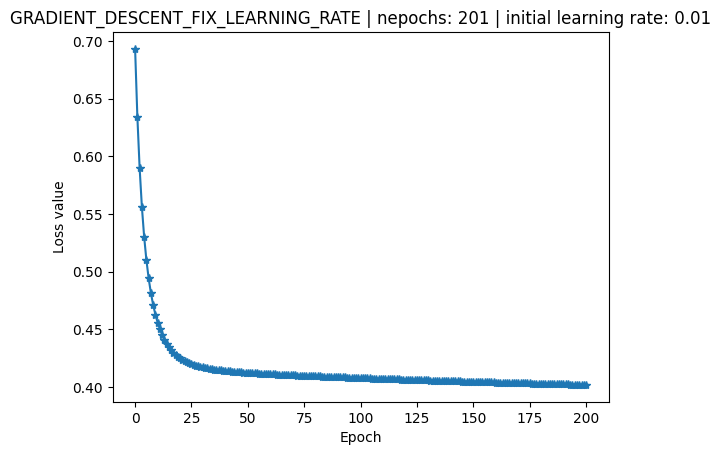

In [494]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.01
MAX_EPOCHS = 200
EPS = 1e-6


# ADDITIONAL PARAMETERS
ALGORITHM_TYPE.value


solution, best_loss_value = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE.name,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
)

### 5.5. GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE | Best value: 0.402214
{'alpha': 0.1, 'beta': 0.8}


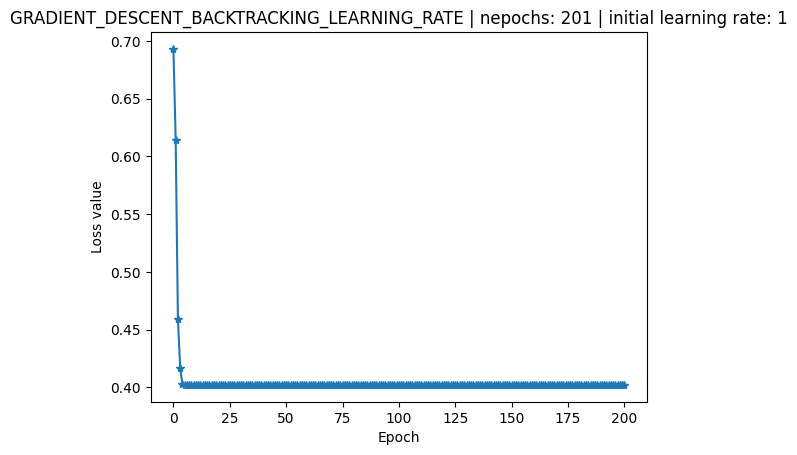

In [495]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 200
EPS = 1e-6

ALPHA = 0.1
BETA = 0.8


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA


solution, best_loss_value = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE.name,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

### 5.6. STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE - randomized

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE | Best value: 0.059886
{'batch_size': 1, 'rule': 0, 'random_seed': 10}


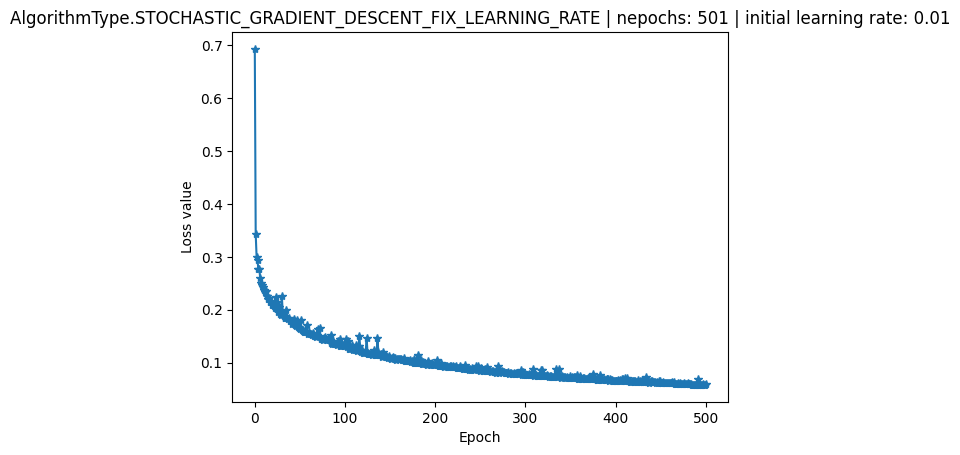

In [496]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.01
MAX_EPOCHS = 500
EPS = 1e-6

BATCH_SIZE = 1
RULE = 0
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED


solution, best_loss_value = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

### 5.7. STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE - cyclic

AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE | Best value: 0.365938
{'batch_size': 1, 'rule': 1, 'random_seed': 10}


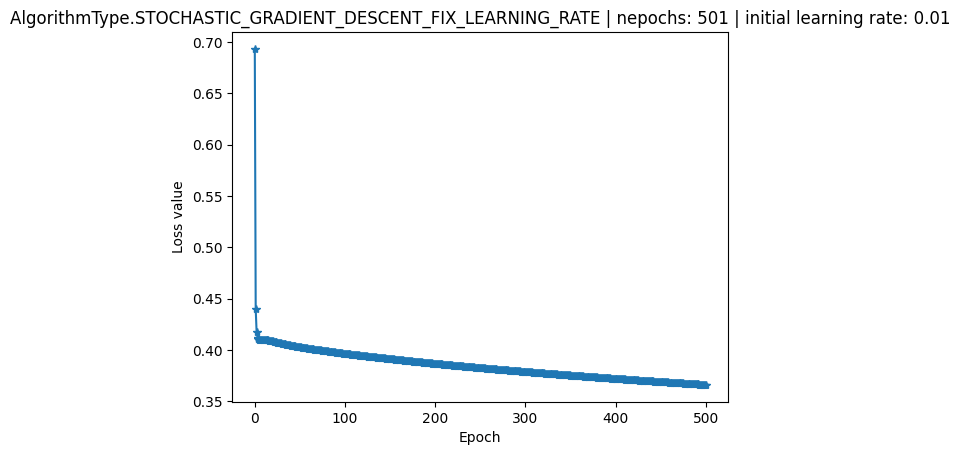

In [497]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.01
MAX_EPOCHS = 500
EPS = 1e-6

BATCH_SIZE = 1
RULE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED


solution, best_loss_value = one_for_all(
    algorithm_type=ALGORITHM_TYPE,
    Xbar=Xbar,
    y=y,
    cost=cost,
    grad=grad,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    algorithm_name=ALGORITHM_TYPE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    marker="*",
    additional_parameters=ADDITIONAL_PARAMETERS,
)

## 6. Algorithms comparison

### 6.1. SKLEARN: SGDClassifier | log loss

Loss value: 0.112774


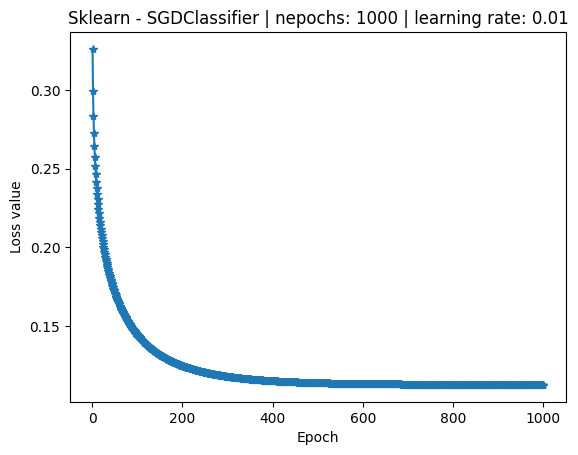

In [498]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.01

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

# Print solution
print(f"Loss value: {log_loss_values[-1]:.6f}")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

### 6.2. The simplest model | log loss

## 7. Conclusion